<a href="https://www.kaggle.com/code/shreyasdomde/weather-detection?scriptVersionId=166135518" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Test Version of Exported Weather Models

In [20]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, callbacks 


import warnings
warnings.filterwarnings("ignore")

In [22]:
# defining hyperparameters
height, width = 150, 150

In [23]:
class Model_Loader:
    
    def __init__(self):
        self.model = self.build_model()
    
    def build_model(self):

        model = tf.keras.Sequential()
        model.add(layers.Resizing(height, width))
        model.add(layers.Rescaling(1/255.0))

        model.add(layers.Flatten())
        model.add(layers.Dense(units=256, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(units=11, activation='softmax'))
        
        return model

In [24]:
model = Model_Loader().build_model()

model.load_weights('C:/Users/D-Redouane/Desktop/mini_apm2/model/training1/vgg16_weights.h5', by_name=True)

# Compile the model (optional, depending on your use case)
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# 🐉Predicting Images of test data

In [25]:
# 🔴🔴🔴
datadir = './dataset'

In [26]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<Axes: >

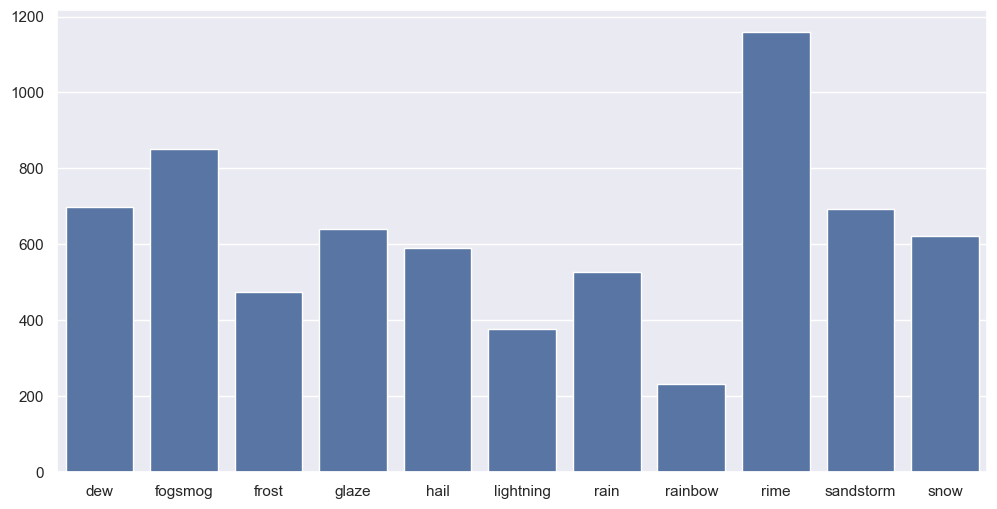

In [27]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

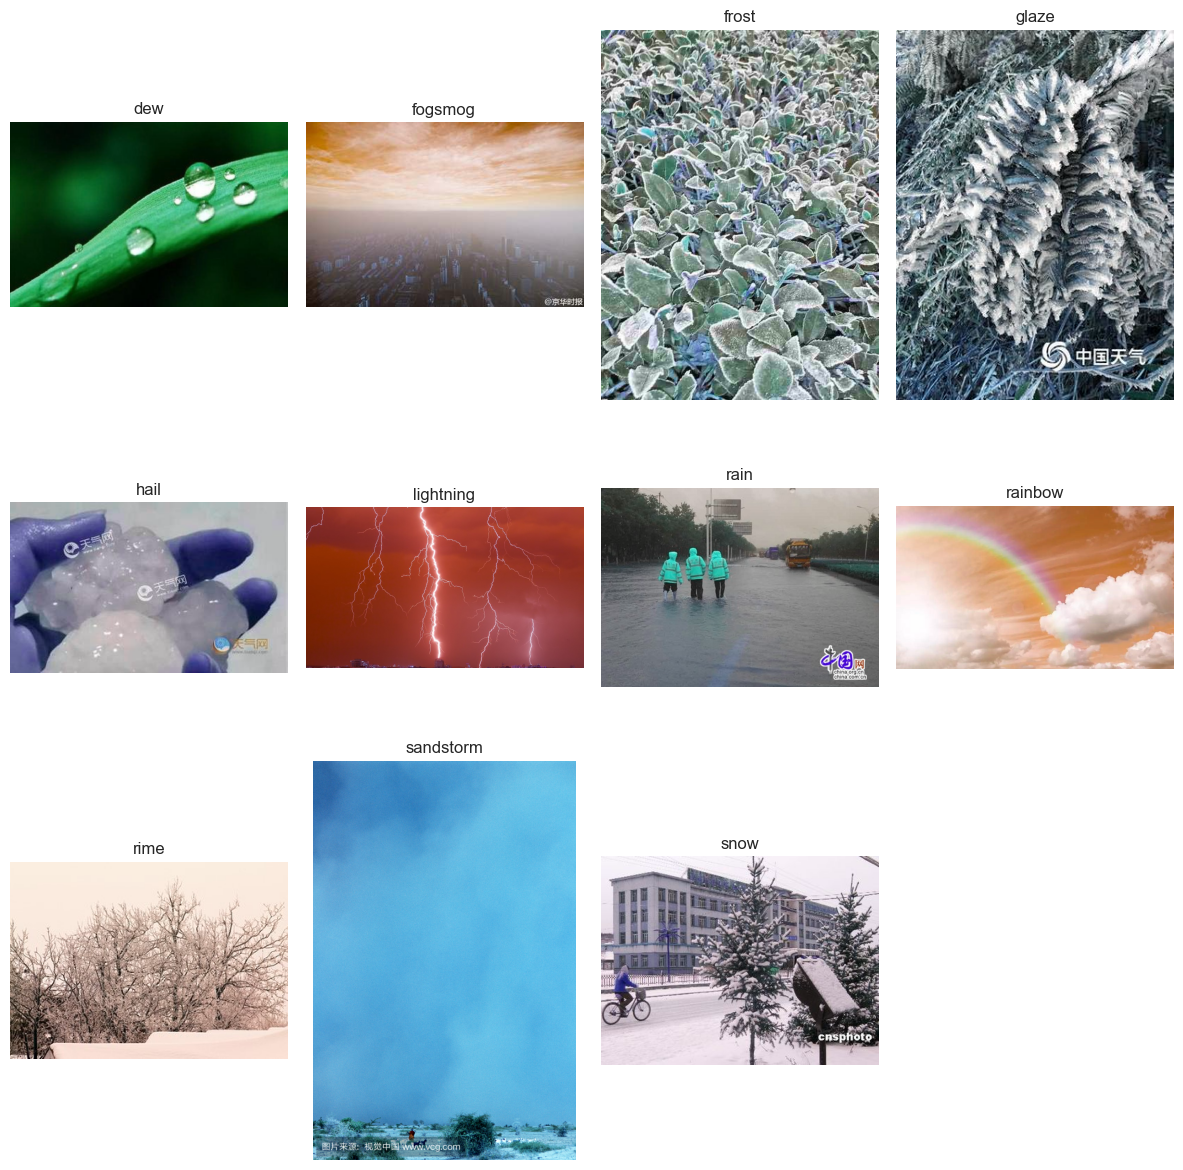

In [28]:
fig = plt.figure(figsize=(12, 12)) 
rows = 3
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(img)
    plt.title(cl)
    
plt.tight_layout()
plt.show()

In [29]:
filepaths = []
labels = []
for i in climates.keys():
    img_path = datadir+'/'+i
    for imgs in os.listdir(img_path):
        filepaths.append(os.path.join(img_path, imgs))
        labels.append(i)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [30]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=44) 

In [31]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [32]:
train_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training'
)

val_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='validation'
)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.


In [33]:
test_data = train_datagen.flow_from_dataframe(
    df_test, 
    x_col = 'filepaths',
    y_col = 'labels',
    color_mode = 'rgb',
    batch_size = 64
)

Found 1373 validated image filenames belonging to 11 classes.


In [34]:
# y_pred = vgg_model.predict(test_data)
y_pred = model.predict(test_data)

22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


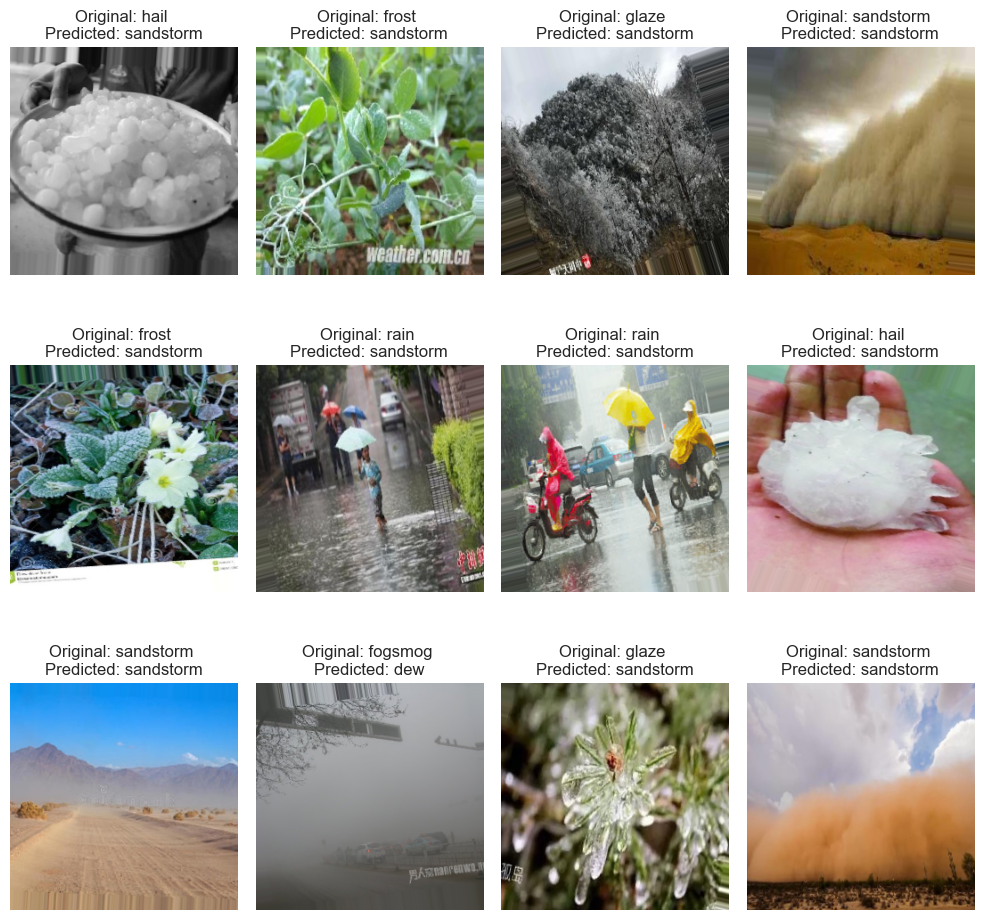

In [35]:
classes = {val:key for key, val in test_data.class_indices.items()}

def vis_pred(ind):
    rows, columns = 3, 4
    x, y = next(iter(test_data))
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(x[ind+i] / 255)
        plt.title(f'Original: {classes[np.argmax(y[ind + i])]} \nPredicted: {classes[np.argmax(y_pred[ind + i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
vis_pred(10)

In [ ]:
#TODO : convert to tflite
# # Convert the SavedModel to a TFLite model
# tflite_model_path = './custom_model.tflite'  # Path to save the TFLite model
# saved_model_path='E:/desktop/M1-S8-STIC/APM2/tp/tp4//mini_apm2/model/training2/xception/xception_model'

# def convert_to_tflite_with_flex(saved_model_dir, tflite_model_path):
#     converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
#     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]  # Enable Flex Ops
    
#     try:
#         tflite_model = converter.convert()  # Convert to TFLite with Flex Ops

#         with open(tflite_model_path, 'wb') as f:
#             f.write(tflite_model)

#         print(f"TFLite model with Flex Ops saved to {tflite_model_path}")
#     except Exception as e:
#         print(f"Error during TFLite conversion with Flex Ops: {e}")

# convert_to_tflite_with_flex(saved_model_path, tflite_model_path)